In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

In [2]:
dan_train = joblib.load('/kaggle/input/international-cp/data/new_train_features.pkl')
dan_test = joblib.load('/kaggle/input/international-cp/data/new_test_features.pkl')

polina_train = joblib.load('/kaggle/input/bk-agg-features-data/train_agg_320_feats_no_corr_no_target.pkl')
polina_test = joblib.load('/kaggle/input/bk-agg-features-data/test_agg_320_feats_no_corr.pkl')

lev_train = joblib.load('/kaggle/input/bk-new-aggr-features/new_train_aggr_features.pkl')
lev_test = joblib.load('/kaggle/input/bk-new-aggr-features/new_test_aggr_features.pkl')

polina_train.reset_index(inplace = True)
polina_test.reset_index(inplace = True)

dan_train = dan_train[['customer_id', 'date_diff_post', 'buy_post', 
        'tfidf_format_name_без', 'tfidf_format_name_внешн',
       'tfidf_format_name_внешней', 'tfidf_format_name_заполнено',
       'tfidf_format_name_зоной', 'tfidf_format_name_зоны',
       'tfidf_format_name_не', 'tfidf_format_name_отдельно',
       'tfidf_format_name_стоящий', 'tfidf_format_name_туалета',
       'tfidf_format_name_туалетом', 'tfidf_format_name_фудкорт',
       'tfidf_dish_name_а4', 'tfidf_dish_name_бокс', 'tfidf_dish_name_бургеры',
       'tfidf_dish_name_говядина', 'tfidf_dish_name_горячие',
       'tfidf_dish_name_десерты', 'tfidf_dish_name_дополнительно',
       'tfidf_dish_name_закуски', 'tfidf_dish_name_картофель',
       'tfidf_dish_name_кинг', 'tfidf_dish_name_коктейли',
       'tfidf_dish_name_комбо', 'tfidf_dish_name_креветки',
       'tfidf_dish_name_купоны', 'tfidf_dish_name_курица',
       'tfidf_dish_name_молочные', 'tfidf_dish_name_напитки',
       'tfidf_dish_name_новинки', 'tfidf_dish_name_обед',
       'tfidf_dish_name_острые', 'tfidf_dish_name_острый',
       'tfidf_dish_name_пиво', 'tfidf_dish_name_роллы', 'tfidf_dish_name_рыба',
       'tfidf_dish_name_салаты', 'tfidf_dish_name_сет',
       'tfidf_dish_name_соусы', 'tfidf_dish_name_топ',
       'tfidf_dish_name_холодные']]
dan_test = dan_test[['customer_id',
        'tfidf_format_name_без', 'tfidf_format_name_внешн',
       'tfidf_format_name_внешней', 'tfidf_format_name_заполнено',
       'tfidf_format_name_зоной', 'tfidf_format_name_зоны',
       'tfidf_format_name_не', 'tfidf_format_name_отдельно',
       'tfidf_format_name_стоящий', 'tfidf_format_name_туалета',
       'tfidf_format_name_туалетом', 'tfidf_format_name_фудкорт',
       'tfidf_dish_name_а4', 'tfidf_dish_name_бокс', 'tfidf_dish_name_бургеры',
       'tfidf_dish_name_говядина', 'tfidf_dish_name_горячие',
       'tfidf_dish_name_десерты', 'tfidf_dish_name_дополнительно',
       'tfidf_dish_name_закуски', 'tfidf_dish_name_картофель',
       'tfidf_dish_name_кинг', 'tfidf_dish_name_коктейли',
       'tfidf_dish_name_комбо', 'tfidf_dish_name_креветки',
       'tfidf_dish_name_купоны', 'tfidf_dish_name_курица',
       'tfidf_dish_name_молочные', 'tfidf_dish_name_напитки',
       'tfidf_dish_name_новинки', 'tfidf_dish_name_обед',
       'tfidf_dish_name_острые', 'tfidf_dish_name_острый',
       'tfidf_dish_name_пиво', 'tfidf_dish_name_роллы', 'tfidf_dish_name_рыба',
       'tfidf_dish_name_салаты', 'tfidf_dish_name_сет',
       'tfidf_dish_name_соусы', 'tfidf_dish_name_топ',
       'tfidf_dish_name_холодные']]

In [3]:
merged_train = dan_train.merge(polina_train, on = 'customer_id', how = 'inner')
merged_train = merged_train.merge(lev_train, on = 'customer_id', how = 'inner')

merged_test = dan_test.merge(polina_test, on = 'customer_id', how = 'inner')
merged_test = merged_test.merge(lev_test, on = 'customer_id', how = 'inner')

## Classification

In [4]:
y = merged_train['buy_post']
X = merged_train.drop(['buy_post'], axis=1)

In [5]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_resampled, y_resampled = under_sampler.fit_resample(X, y)

In [6]:
from sklearn.model_selection import train_test_split

y_buy = y_resampled
y_days = X_resampled['date_diff_post']
X = X_resampled.drop(['customer_id', 'date_diff_post'], axis=1)

X_train, X_valid, y_train_buy, y_valid_buy, y_train_days, y_valid_days = train_test_split(X, y_buy, y_days, random_state=42, shuffle=True, stratify = y_buy,test_size=0.3)

In [7]:
from catboost import CatBoostClassifier, metrics
CatBoostModel = CatBoostClassifier(
    iterations= 500,
    learning_rate = 0.065,
    use_best_model = True,
    eval_metric ='F1', 
    loss_function='Logloss',
    random_seed = 42,
    depth = 5,
    verbose = 100
)

In [8]:
CatBoostModel.fit(
    X_train, y_train_buy,
    eval_set=(X_valid, y_valid_buy)
)

0:	learn: 0.6227125	test: 0.6185044	best: 0.6185044 (0)	total: 289ms	remaining: 2m 24s
100:	learn: 0.6547015	test: 0.6505420	best: 0.6522378 (14)	total: 21.8s	remaining: 1m 26s
200:	learn: 0.6577828	test: 0.6512560	best: 0.6522378 (14)	total: 39.8s	remaining: 59.2s
300:	learn: 0.6609423	test: 0.6519424	best: 0.6522778 (233)	total: 56.9s	remaining: 37.6s
400:	learn: 0.6642799	test: 0.6519710	best: 0.6522778 (233)	total: 1m 13s	remaining: 18.1s
499:	learn: 0.6666631	test: 0.6520830	best: 0.6522778 (233)	total: 1m 30s	remaining: 0us

bestTest = 0.6522778193
bestIteration = 233

Shrink model to first 234 iterations.


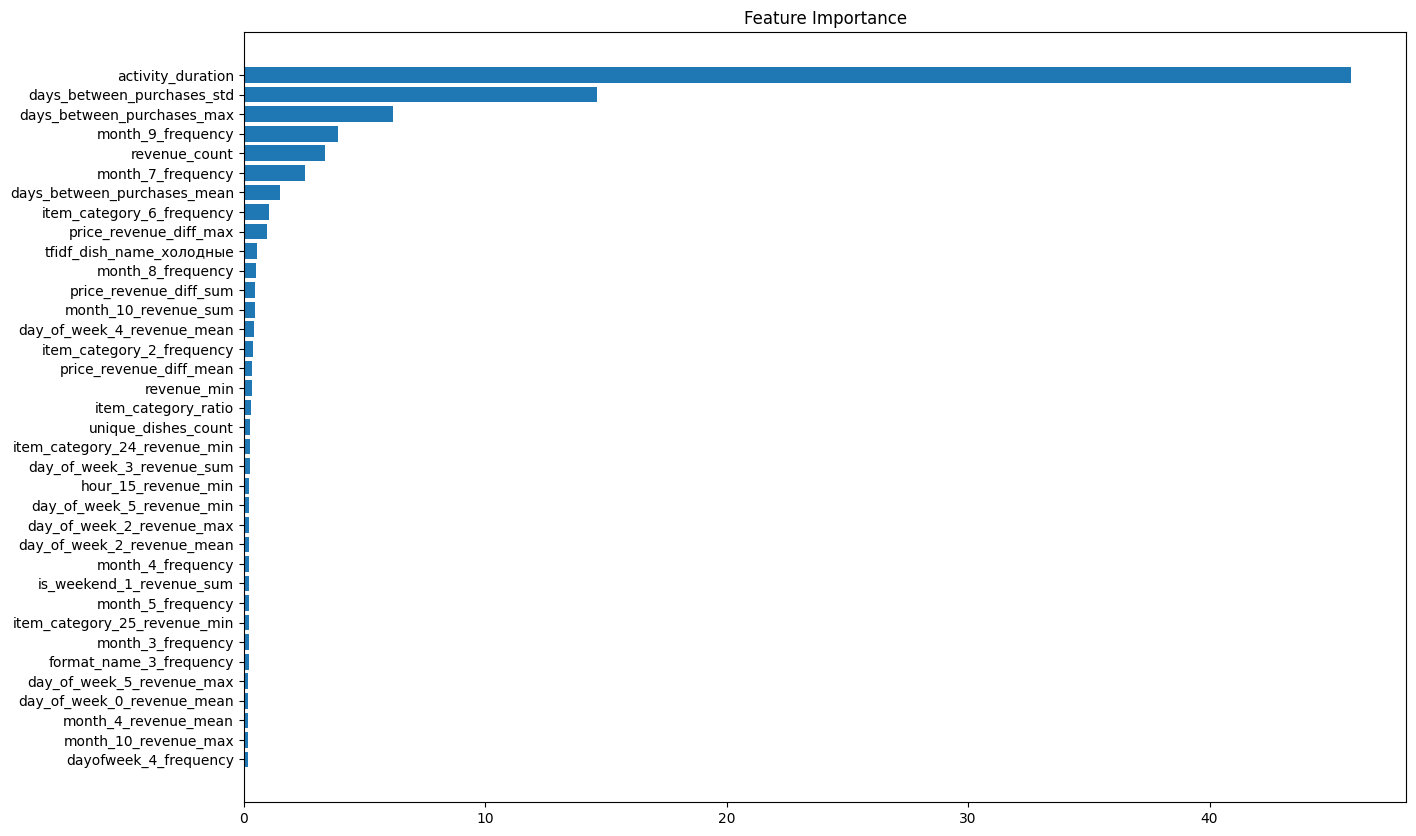

In [9]:
feature_importance = CatBoostModel.feature_importances_
sorted_idx = np.argsort(feature_importance)[330:]

plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(CatBoostModel.feature_names_)[sorted_idx])
plt.title("Feature Importance")
plt.show()

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

predictions_auc = CatBoostModel.predict_proba(X_valid)[:, 1]
print(f'roc_auc: {roc_auc_score(y_valid_buy, predictions_auc)}')

predictions = CatBoostModel.predict(X_valid)
print(f'f1: {f1_score(y_valid_buy, predictions)}')
print(f'precision: {precision_score(y_valid_buy, predictions)}')
print(f'recall: {recall_score(y_valid_buy, predictions)}')

roc_auc: 0.7364865766633093
f1: 0.6522778192681105
precision: 0.688276550474139
recall: 0.6198575855787656


In [11]:
predictions_val = CatBoostModel.predict(X_valid)
predictions_test = CatBoostModel.predict(merged_test[CatBoostModel.feature_names_])

In [12]:
from collections import Counter
print(Counter(predictions_val))
print(Counter(predictions_test))

Counter({0: 46474, 1: 38069})
Counter({0: 61733, 1: 50601})


In [13]:
merged_test['preds'] = predictions_test

In [14]:
submit = pd.read_csv('/kaggle/input/international-cp/submission.csv', sep = ';')

In [15]:
submit = submit.merge(merged_test[['customer_id', 'preds']], on = 'customer_id', how = 'inner')

In [16]:
submit['buy_post'] = submit['preds']
submit.drop(columns = ['preds'], inplace = True)

In [17]:
submit.to_csv('merged_all_dpl_0045.csv', sep = ';', index = False)

In [18]:
with open('best_model_dpl_067_0045.pkl', "wb") as f:
    pickle.dump(CatBoostModel, f)

## Visualisation

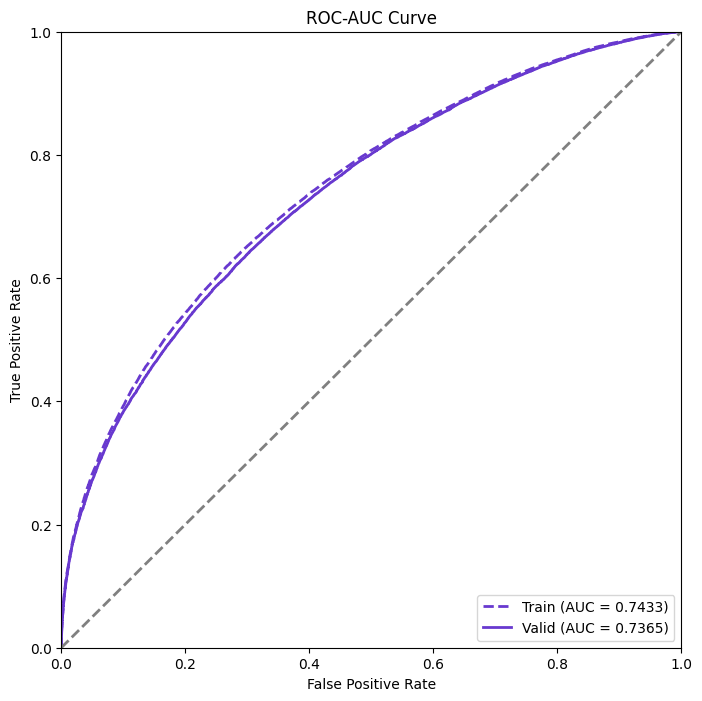

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label, color, linestyle):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.4f})', linestyle=linestyle)

y_true_train = y_train_buy
y_scores_train = CatBoostModel.predict_proba(X_train)[:, 1]

y_true_valid = y_valid_buy
y_scores_valid = CatBoostModel.predict_proba(X_valid)[:, 1]

roc_auc_color = '#6839CF'

plt.figure(figsize=(8, 8))

plot_roc_curve(y_true_train, y_scores_train, 'Train', color=roc_auc_color, linestyle='--')

plot_roc_curve(y_true_valid, y_scores_valid, 'Valid', color=roc_auc_color, linestyle='-')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")

plt.show()

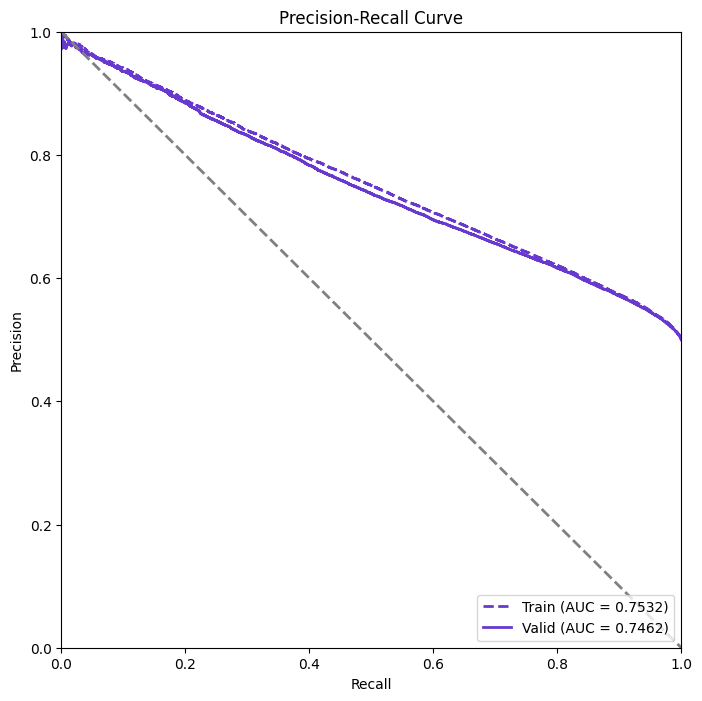

In [20]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(y_true, y_scores, label, color, linestyle):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, color=color, lw=2, label=f'{label} (AUC = {pr_auc:.4f})', linestyle=linestyle)

y_true_train = y_train_buy
y_scores_train = CatBoostModel.predict_proba(X_train)[:, 1]

y_true_valid = y_valid_buy
y_scores_valid = CatBoostModel.predict_proba(X_valid)[:, 1]

pr_auc_color = '#6839CF'

plt.figure(figsize=(8, 8))

plot_pr_curve(y_true_train, y_scores_train, 'Train', color=pr_auc_color, linestyle='--')

plot_pr_curve(y_true_valid, y_scores_valid, 'Valid', color=pr_auc_color, linestyle='-')

plt.plot([0, 1], [1, 0], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

plt.show()

## Regression

In [27]:
preds = CatBoostModel.predict(merged_train[CatBoostModel.feature_names_])
merged_train['preds'] = preds

preds_prob = CatBoostModel.predict_proba(merged_train[CatBoostModel.feature_names_])[:, 1]
merged_train['preds_prob'] = preds_prob

In [28]:
merged_train_reg = merged_train[merged_train['preds'] == 1]

In [29]:
merged_train_reg['date_diff_post'].fillna(0, inplace = True)

In [36]:
from sklearn.model_selection import train_test_split

y_days = merged_train_reg['date_diff_post']
X = merged_train_reg.drop(['customer_id', 'date_diff_post', 'preds', 'buy_post'], axis=1)

X_train, X_valid, y_train_days, y_valid_days = train_test_split(X, y_days, random_state=42, shuffle=True, test_size=0.3)

In [37]:
from catboost import CatBoostRegressor, metrics
cb_regr = CatBoostRegressor(
    iterations= 500,
    use_best_model = True,
    eval_metric ='RMSE', 
    loss_function='RMSE',
    random_seed = 42,
    verbose = 100
)

In [38]:
cb_regr.fit(
    X_train, y_train_days,
    eval_set=(X_valid, y_valid_days)
)

Learning rate set to 0.17625
0:	learn: 14.8655638	test: 14.8416648	best: 14.8416648 (0)	total: 227ms	remaining: 1m 53s
100:	learn: 14.3123671	test: 14.4077481	best: 14.4077481 (100)	total: 19.9s	remaining: 1m 18s
200:	learn: 14.1630877	test: 14.4046534	best: 14.3998188 (121)	total: 38.2s	remaining: 56.8s
300:	learn: 14.0285003	test: 14.4066840	best: 14.3998188 (121)	total: 56s	remaining: 37s
400:	learn: 13.8983277	test: 14.4138297	best: 14.3998188 (121)	total: 1m 14s	remaining: 18.4s
499:	learn: 13.7756963	test: 14.4205209	best: 14.3998188 (121)	total: 1m 32s	remaining: 0us

bestTest = 14.39981879
bestIteration = 121

Shrink model to first 122 iterations.


In [39]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

preds = cb_regr.predict(X_valid)
print(f'r2: {r2_score(y_valid_days, preds)}')
print(f'mse: {mean_squared_error(y_valid_days, preds)}')
print(f'rmse: {mean_squared_error(y_valid_days, preds, squared = False)}')
print(f'mae: {mean_absolute_error(y_valid_days, preds)}')

r2: 0.07474363786273419
mse: 207.35478119343284
rmse: 14.399818790298468
mae: 11.309989162029451


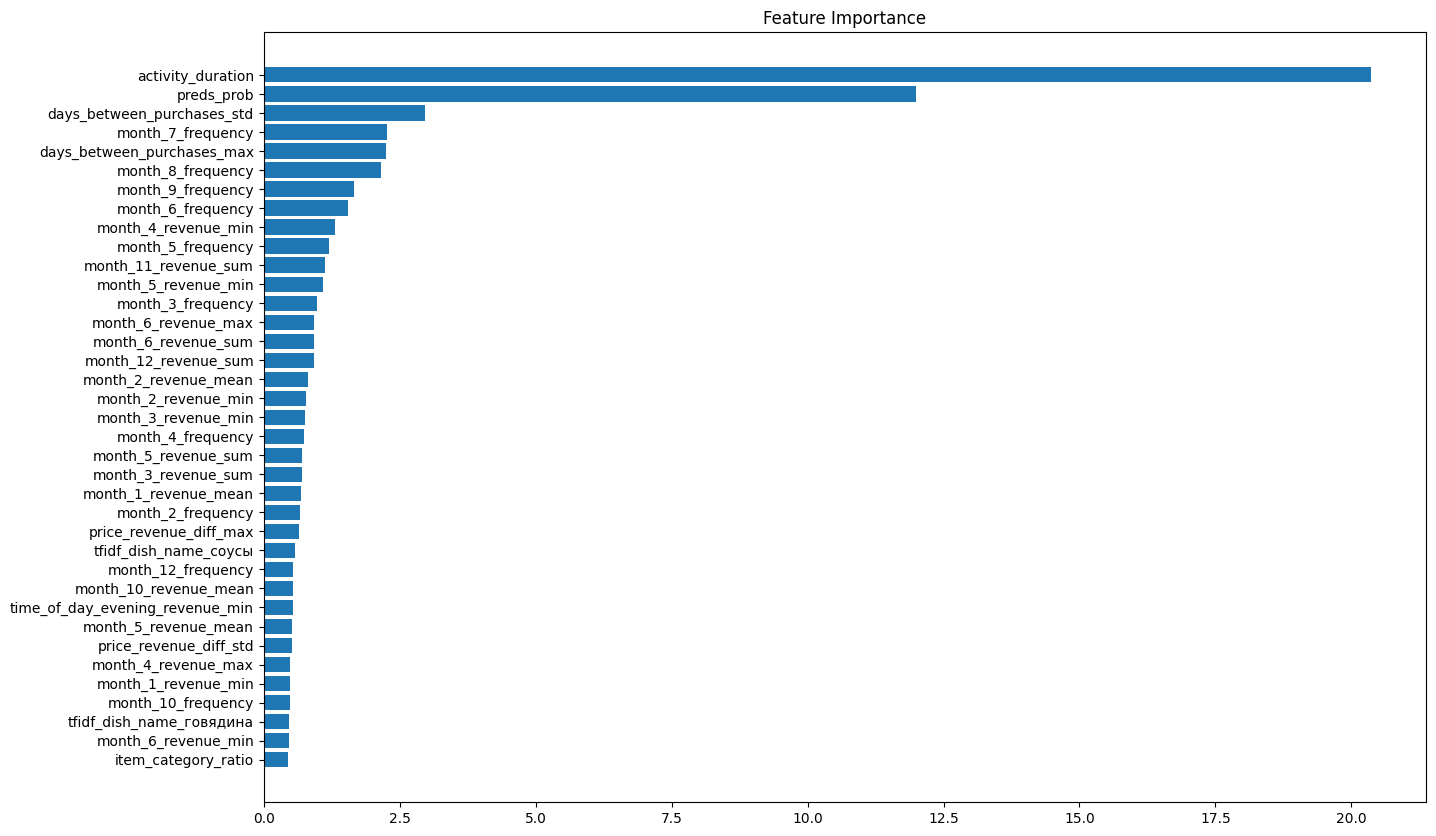

In [40]:
feature_importance = cb_regr.feature_importances_
sorted_idx = np.argsort(feature_importance)[330:]

plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cb_regr.feature_names_)[sorted_idx])
plt.title("Feature Importance")
plt.show()

In [ ]:
import optuna

def objective(trial):
    params = {
        "objective": "RMSE",  # Changed to RMSE for regression
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 2, 5),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 50),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 50),
        "iterations": trial.suggest_int("iterations", 500, 3500),
        "eval_metric": "RMSE"
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = CatBoostRegressor(
        loss_function='RMSE',
        random_seed=42,
        task_type='CPU',
        use_best_model=True,
        verbose=False,
        **params
    )
    
    model.fit(
        X_train, y_train_days,
        eval_set=(X_valid, y_valid_days)
    )

    y_pred = model.predict(X_valid)

    rmse = mean_squared_error(y_valid_days, y_pred, squared = False)

    return rmse

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "minimize")
study.optimize(objective, n_trials = 100, timeout = 1800)

print("Best params:", study.best_params)

[I 2023-11-24 22:01:02,825] A new study created in memory with name: no-name-bc6f04e1-000e-4455-a2f1-e522477efc81
